## What is Stacking?

Stacking is a technique where multiple Base Models are trained on the same dataset. After this, the predictions of these models are used as the input features of a seperate model, called the Meta Model. This is similar to other techniques such as Bagging and Boosting but stacking can use any models where as the Bagged and Boosted models are more specific on their base model needs.

Stacking is advantageous when you need to leverage different models with different strengths to tackle multiple problems in one model.

### How Stacking Works

1. Each base model, in this instance we have Random Forest, Gradient Boosting, and a Decision Tree, are trained on the full dataset. Like any other predictive model you run, it will make predictions on the data set.

2. A new dataset is created with the predictions of the base models. This is called the meta data set and is used to train the meta model. Each column is the predictions of a base model.

3. The new meta model is typically a simple model like Linear/Logistic Regression. This is used to learn the relationships and patterns between the predictions of the base models. It helps pinpoint where a base model is successful in predictions and where its weaknesses are. It puts certain weights on these areas.

4. The meta model then makes predictions on the original training data.

### Data Loading and Preprocessing

The dataset is loaded from a CSV file.

The plan is to use tree-based models. Since there are little preprocessing steps requiredf or tree-based models and it can robustly handle class imbalance, the processing is minimal.

In [1]:
import numpy as np 
import pandas as pd 

df = pd.read_csv("Base.csv")

df = df.drop('device_fraud_count', axis=1, inplace=False)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

### Visualizing Distributions

Here the distribution of the numerical columns is visualized. As is typical for fraud datasets some of the columns show heavy left skewness. 

With the selection of tree based models, fixing the skewness is not as important since the model are non-linear and can handle things like missing values and skewness fairly well. It does not hurt though to transform some of these columns to help.

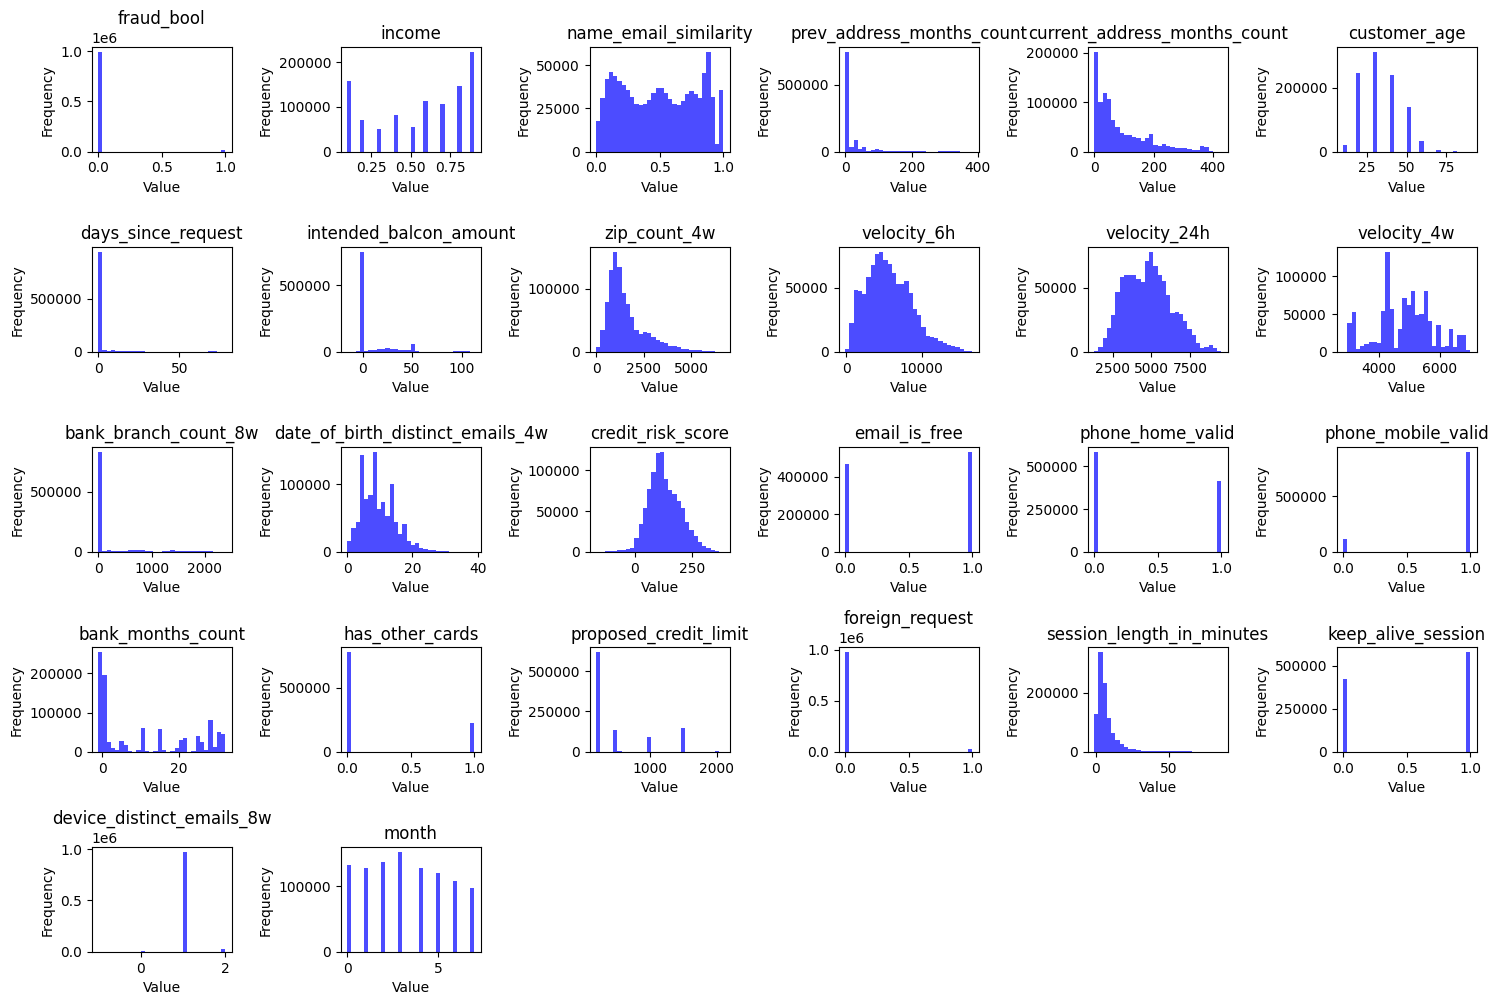

In [2]:
import matplotlib.pyplot as plt
import math

numerical_df = df.select_dtypes(include=['number'])

num_columns = numerical_df.shape[1]
num_rows = math.ceil(num_columns / 6)

fig, axes = plt.subplots(num_rows, 6, figsize=(15, num_rows * 2))
axes = axes.flatten()

for i, col in enumerate(numerical_df.columns):
    axes[i].hist(numerical_df[col].dropna(), bins=30, color='blue', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Here the we test the numerical columns to see if its skewed or not, leaving out binary columns. 

Also, if the value is negative, the smallest value is found, the absolute value plus 1 is added to shift all values to postive for the log transformation.

Once the skewed columns are found, they are log transformed and visualized again.

The distributions look more spread out, and even though there is still skewed data, its more evenly spread than before.

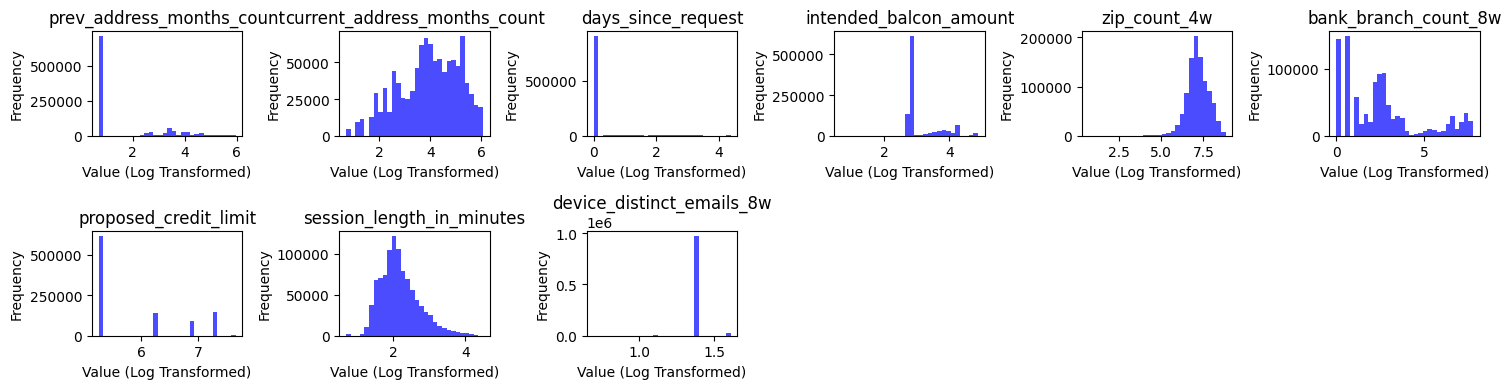

In [3]:
skew_threshold = 1

skewed_columns = []
for col in df.select_dtypes(include=['number']).columns:
    if df[col].nunique() == 2:
        continue
    if df[col].skew() > skew_threshold:
        skewed_columns.append(col)

for col in skewed_columns:

    df[col] = df[col].fillna(0)
    
    if (df[col] < 0).any():
        min_value = df[col].min()
        shift_value = abs(min_value) + 1
        df[col] = df[col] + shift_value
    
    df[col] = np.log1p(df[col])

num_cols = len(skewed_columns)
num_rows = (num_cols + 4) // 6

fig, axes = plt.subplots(num_rows, 6, figsize=(15, num_rows * 2))
axes = axes.flatten()

for i, col in enumerate(skewed_columns):
    axes[i].hist(df[col].dropna(), bins=30, color='blue', alpha=0.7)
    axes[i].set_title(col)
    axes[i].set_xlabel('Value (Log Transformed)')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Here the categorical columns are summarized to get a better idea of what the data looks like.

Here, the distribution count and percentage are shown.

In [4]:
categorical_columns = df.select_dtypes(include=['object', 'category'])

categorical_summary = {}
for col in categorical_columns.columns:
    counts = categorical_columns[col].value_counts(dropna=False)
    percentages = counts / len(categorical_columns) * 100
    categorical_summary[col] = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    })

for col, summary in categorical_summary.items():
    print(f"Summary for {col}:")
    print(summary)


Summary for payment_type:
               Count  Percentage
payment_type                    
AB            370554     37.0554
AA            258249     25.8249
AC            252071     25.2071
AD            118837     11.8837
AE               289      0.0289
Summary for employment_status:
                    Count  Percentage
employment_status                    
CA                 730252     73.0252
CB                 138288     13.8288
CF                  44034      4.4034
CC                  37758      3.7758
CD                  26522      2.6522
CE                  22693      2.2693
CG                    453      0.0453
Summary for housing_status:
                 Count  Percentage
housing_status                    
BC              372143     37.2143
BB              260965     26.0965
BA              169675     16.9675
BE              169135     16.9135
BD               26161      2.6161
BF                1669      0.1669
BG                 252      0.0252
Summary for source:
       

The categorical columns are now given numerical labels from LabelEncoder. This is necessary for the models since they require numerical columns.

In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = df.select_dtypes(include=['object', 'category']).columns

label_encoder = LabelEncoder()

for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

### Handling Class Imbalanace with Resampling

The dataset is extremely imbalanced, even for tree-based models. Fraud cases are around 10,000 which is only 1% of the non-fraud cases around 1,000,000. This will skew the accuracy measurements of the model. Even if we predict all cases to be non-fraud we will get a 99% accuracy rating. While the number is good, we accomplish nothing since we are trying to be able to predict fraud cases. 

Here undersampling is used to help class imbalance. We reduce to the majority case from 1,000,000 to 100,000 so that the results are more meaningful.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

df_majority = df[df['fraud_bool'] == 0]
df_minority = df[df['fraud_bool'] == 1]

df_majority_undersampled = resample(df_majority, 
                                    replace=False,       
                                    n_samples=100000,
                                    random_state=42)

df_undersampled = pd.concat([df_majority_undersampled, df_minority])

y = df_undersampled['fraud_bool']
x = df_undersampled.drop('fraud_bool', axis=1, inplace=False)

### Splitting the Dataset

After the processing of data, the data is split into a 60-40 split. This allows us to train the model on 60% of the data and test and validate the model on 40$ of the data.

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.40, random_state=42)

### Model Training and Evaluation

Three models are trained, wach with its own report and confusion matrix for evaluation. The metrics are saved for a comparison table at the end.

The metrics used to evaluate are Accuracy, Precision, Recall, and F1 Score.

In [8]:
from sklearn.metrics import classification_report, accuracy_score

model_metrics = []

### Random Forest

First, is Random Forest. This is an ensemble(a group of items viewed as a whole) model that uses multiple decision trees to improve accuracy and overfitting. The number of trees in this example is 100.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(x_train, y_train)
y_pred_rf = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_rf)
report = classification_report(y_test, y_pred_rf, output_dict=True)

model_metrics.append({
    "Model": "Random Forest", 
    "Accuracy": accuracy,
    "Precision (Weighted Avg)": report['weighted avg']['precision'],
    "Recall (Weighted Avg)": report['weighted avg']['recall'],
    "F1-score (Weighted Avg)": report['weighted avg']['f1-score']
})

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.99      0.95     40070
           1       0.71      0.19      0.30      4342

    accuracy                           0.91     44412
   macro avg       0.81      0.59      0.63     44412
weighted avg       0.90      0.91      0.89     44412

Random Forest Confusion Matrix:
 [[39731   339]
 [ 3508   834]]


### Gradient Boosting

Second, is Gradient Boosing. This is a boosting algorith that builds trees sequentially to correct the errors of the previous tree. Like Random Forest, this helps improve the accuracy of the model.

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(x_train, y_train)
y_pred_gb = gb_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_gb)
report = classification_report(y_test, y_pred_gb, output_dict=True)

model_metrics.append({
    "Model": "Gradient Boosting", 
    "Accuracy": accuracy,
    "Precision (Weighted Avg)": report['weighted avg']['precision'],
    "Recall (Weighted Avg)": report['weighted avg']['recall'],
    "F1-score (Weighted Avg)": report['weighted avg']['f1-score']
})

print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96     40070
           1       0.69      0.32      0.43      4342

    accuracy                           0.92     44412
   macro avg       0.81      0.65      0.70     44412
weighted avg       0.91      0.92      0.91     44412

Gradient Boosting Confusion Matrix:
 [[39464   606]
 [ 2973  1369]]


### Decision Tree

Last, is a Decision Tree. This is one simple tree that splits data based on values of the features. This, like many basic models, is useful for baseline estimates for other, stronger methods, like the ones above.

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(x_train, y_train)
y_pred_dt = dt_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_dt)
report = classification_report(y_test, y_pred_dt, output_dict=True)

model_metrics.append({
    "Model": "Decision Tree", 
    "Accuracy": accuracy,
    "Precision (Weighted Avg)": report['weighted avg']['precision'],
    "Recall (Weighted Avg)": report['weighted avg']['recall'],
    "F1-score (Weighted Avg)": report['weighted avg']['f1-score']
})

print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Decision Tree Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93     40070
           1       0.33      0.34      0.33      4342

    accuracy                           0.87     44412
   macro avg       0.63      0.63      0.63     44412
weighted avg       0.87      0.87      0.87     44412

Decision Tree Confusion Matrix:
 [[37066  3004]
 [ 2887  1455]]


### Stacking Models

Here, stacking is used. Stacking is a technique that combines multiple models to improve predictive performance. Like Random Forest with tree, stacking does it with models. In this example the same three models are used as above to stack on top of each other to improve accuracy.

In stacking we have:

Base models: Here Random Forest, Gradient Boosting, and a Decision Tree is used. They independently of each other learn patterns in the data to predict.

Meta Model: In this example, a Logistic Regression model is used as the final model to take predictions of base models as inputs and learn how best to combine them to improve the predictions.

In [12]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

base_estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('dt', DecisionTreeClassifier(class_weight='balanced', random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_estimators,
    final_estimator=LogisticRegression(random_state=42)
)

stacking_model.fit(x_train, y_train)
y_pred_stacking = stacking_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred_stacking)
report = classification_report(y_test, y_pred_stacking, output_dict=True)

model_metrics.append({
    "Model": "Stacking Model", 
    "Accuracy": accuracy,
    "Precision (Weighted Avg)": report['weighted avg']['precision'],
    "Recall (Weighted Avg)": report['weighted avg']['recall'],
    "F1-score (Weighted Avg)": report['weighted avg']['f1-score']
})

print("Stacking Model with Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_stacking))
print("Stacking Model with Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_stacking))


Stacking Model with Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.96     40070
           1       0.66      0.35      0.46      4342

    accuracy                           0.92     44412
   macro avg       0.80      0.66      0.71     44412
weighted avg       0.91      0.92      0.91     44412

Stacking Model with Logistic Regression Confusion Matrix:
 [[39306   764]
 [ 2834  1508]]


### Metrics

Here are the final statistics and ranks of the models.

In [13]:
metrics_df = pd.DataFrame(model_metrics)

for metric in ["Accuracy", "Precision (Weighted Avg)", "Recall (Weighted Avg)", "F1-score (Weighted Avg)"]:
    metrics_df[f"{metric} Rank"] = metrics_df[metric].rank(ascending=False, method='min')

print(metrics_df)

               Model  Accuracy  Precision (Weighted Avg)  \
0      Random Forest  0.913379                  0.898547   
1  Gradient Boosting  0.919414                  0.906794   
2      Decision Tree  0.867356                  0.868940   
3     Stacking Model  0.918986                  0.906447   

   Recall (Weighted Avg)  F1-score (Weighted Avg)  Accuracy Rank  \
0               0.913379                 0.890140            3.0   
1               0.919414                 0.905472            1.0   
2               0.867356                 0.868140            4.0   
3               0.918986                 0.907328            2.0   

   Precision (Weighted Avg) Rank  Recall (Weighted Avg) Rank  \
0                            3.0                         3.0   
1                            1.0                         1.0   
2                            4.0                         4.0   
3                            2.0                         2.0   

   F1-score (Weighted Avg) Rank  
0  

### Results

Based on the ranks of the models, it seems that Gradient Boosting actually performed slightly better than the Stacking Model. It scored rank 1 on everything except F1-Score but only by a miniscule margin. Infact most of the models perform quite well. 

Taking into account the complexity of each model it would seem that Stacking is not neccesary in this particular case and maybe require a better base model selection, especially since Decision Trees are obsolete as major predictive models.